# Table of Contents
* [overview](#overview)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
from tqdm import tqdm as tqdm
from collections import defaultdict
from collections import Counter
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

import os
import cv2
import PIL.Image as Image

# overview

<img  src="robot_dataset_section.jpg"/>

# THOR interface

In [9]:
from thor_interface.scene_data import get_scene_metadata
from thor_interface.scene_data import multiscene

In [43]:
import ai2thor.controller
import pickle
import json


controller = ai2thor.controller.Controller()

In [44]:
def get_scene_metadata(scene_id):
    print(scene_id)
    controller.reset(scene_id)
    meta_event = controller.step(dict(action='Initialize', gridSize=0.25))
    return meta_event.metadata

In [151]:
used_arget_objs = ['Television', 'Mug', 'Apple', 'AlarmClock', 'BasketBall']


all_targets = [
                'AlarmClock',  
                'Apple',
                'BaseballBat',
                'BasketBall',
                'Bowl',
                'GarbageCan',
                'HousePlant',
                'Laptop',
                'Mug',
                'Pillow',
                'RemoteControl',
                'SprayBottle',
                'Television',
                'Vase',
            ]


furn_vs_obj_def = {
    'ArmChair': 'furniture',
    'Bed': 'furniture',
     'Book': 'object',
     'Bowl': 'object',
     'Newspaper': 'object',
     'SaltShaker': 'object', 
     'PepperShaker': 'object', 
     'ButterKnife': 'object',
     'Candle': 'object',
     'Pen': 'object',
     'Pencil': 'object',
     'TennisRacket': 'object',
     'TeddyBear': 'object',
     'BasketBall': 'object',
     'CD': 'object',
     'Lamp': 'object',
     'Chair': 'furniture',
     'Ottoman': 'furniture',
     'CoffeeTable': 'furniture',
     'TVStand': 'furniture',
     'Desk': 'furniture',
     'DeskLamp': 'object',
     'DiningTable': 'furniture',
     'Dresser': 'furniture',
     'Drawer': 'furniture',
     'Fork': 'object',
     'HousePlant': 'object',
     'Mug': 'object',
     'Plate': 'object',
     'Shelf': 'furniture',
     'SideTable': 'furniture',
     'Sofa': 'furniture',
     'FloorLamp': 'furniture',
     'Box': 'object',
     'Vase': 'object',
     'Glassbottle': 'object',
     'GarbageCan': 'object',
     'SprayBottle': 'object',
     'Cup': 'object',
     'BaseballBat': 'object',
     'Television': 'object',
     'Pillow': 'object',
     'CellPhone': 'object',
     'Apple': 'object',
     'Pot': 'object',
     'Watch': 'object',
     'Statue': 'object',
     'Laptop': 'object',
     'AlarmClock': 'object',
     'RemoteControl': 'object',
}

In [152]:
furn_obj_df['category'] = furn_obj_df.objectType.apply(lambda x: furn_vs_obj_def[x])

In [45]:
controller.start()
multi_scene_data = {scene_id: get_scene_metadata(scene_id) for scene_id in all_scenes}
controller.stop() 

FloorPlan_Train10_1
FloorPlan_Train10_2
FloorPlan_Train10_3
FloorPlan_Train10_4
FloorPlan_Train10_5
FloorPlan_Train11_1
FloorPlan_Train11_2
FloorPlan_Train11_3
FloorPlan_Train11_4
FloorPlan_Train11_5
FloorPlan_Train12_1
FloorPlan_Train12_2
FloorPlan_Train12_3
FloorPlan_Train12_4
FloorPlan_Train12_5
FloorPlan_Train13_1
FloorPlan_Train13_2
FloorPlan_Train13_3
FloorPlan_Train13_4
FloorPlan_Train13_5
FloorPlan_Train14_1
FloorPlan_Train14_2
FloorPlan_Train14_3
FloorPlan_Train14_4
FloorPlan_Train14_5
FloorPlan_Train15_1
FloorPlan_Train15_2
FloorPlan_Train15_3
FloorPlan_Train15_4
FloorPlan_Train15_5
FloorPlan_Train1_1
FloorPlan_Train1_2
FloorPlan_Train1_3
FloorPlan_Train1_4
FloorPlan_Train1_5
FloorPlan_Train2_1
FloorPlan_Train2_2
FloorPlan_Train2_3
FloorPlan_Train2_4
FloorPlan_Train2_5
FloorPlan_Train3_1
FloorPlan_Train3_2
FloorPlan_Train3_3
FloorPlan_Train3_4
FloorPlan_Train3_5
FloorPlan_Train4_1
FloorPlan_Train4_2
FloorPlan_Train4_3
FloorPlan_Train4_4
FloorPlan_Train4_5
FloorPlan_Train5_1
F

In [167]:
to = test_md['objects'][0]

In [168]:
to

{'name': 'CoffeeTable_d5ef56ac',
 'position': {'x': 9.512, 'y': 0.0, 'z': -2.26},
 'rotation': {'x': 0.0, 'y': 269.999664, 'z': 0.0},
 'cameraHorizon': 0.0,
 'visible': False,
 'receptacle': True,
 'toggleable': False,
 'isToggled': False,
 'breakable': False,
 'isBroken': False,
 'canFillWithLiquid': False,
 'isFilledWithLiquid': False,
 'dirtyable': False,
 'isDirty': False,
 'canBeUsedUp': False,
 'isUsedUp': False,
 'cookable': False,
 'isCooked': False,
 'ObjectTemperature': 'RoomTemp',
 'canChangeTempToHot': False,
 'canChangeTempToCold': False,
 'sliceable': False,
 'isSliced': False,
 'openable': False,
 'isOpen': False,
 'pickupable': False,
 'isPickedUp': False,
 'mass': 0.0,
 'salientMaterials': None,
 'receptacleObjectIds': ['Vase|+09.67|+00.47|-02.44',
  'DeskLamp|+09.57|+00.47|-02.71',
  'Mug|+09.36|+00.47|-02.23',
  'Cup|+09.39|+00.47|-02.52',
  'HousePlant|+09.50|+00.47|-01.87'],
 'distance': 6.61782026,
 'objectType': 'CoffeeTable',
 'objectId': 'CoffeeTable|+09.51|+00

In [169]:
relevant_fields = ['name', 'objectType', 'objectId', 'position']

build_furn_obj_df = []
for scene, objects in multi_scene_data.items():
    scene_objects = [{f: o[f] for f in relevant_fields} for o in objects['objects']]
    _ = [o.update({'scene': scene}) for o in scene_objects]
    build_furn_obj_df.extend(scene_objects)

In [170]:
def label_targets(obj_cat):
    if obj_cat in used_arget_objs:
        return 'target'
    if obj_cat in all_targets:
        
        return 'expanded target'
    else:
        return 'background'

In [171]:
furn_obj_df = pd.DataFrame(build_furn_obj_df)
furn_obj_df['category'] = furn_obj_df.objectType.apply(lambda x: furn_vs_obj_def[x])
furn_obj_df['role'] = furn_obj_df.objectType.apply(label_targets)

In [172]:
furn_obj_df.name.value_counts().shape

(866,)

In [174]:
furn_obj_df['z'] = furn_obj_df['position'].apply(lambda x: x['z'])
furn_obj_df['x'] = furn_obj_df['position'].apply(lambda x: x['x'])

In [247]:
furn_obj_df

,name,objectId,objectType,position,scene,category,role,z,x
0,CoffeeTable_d5ef56ac,CoffeeTable|+09.51|+00.00|-02.26,CoffeeTable,"{'x': 9.512, 'y': 0.0, 'z': -2.26}",FloorPlan_Train10_1,furniture,background,-2.260000,9.512000
1,ArmChair_d46035d3,ArmChair|+04.06|+00.00|-03.04,ArmChair,"{'x': 4.0553, 'y': 0.0, 'z': -3.03820014}",FloorPlan_Train10_1,furniture,background,-3.038200,4.055300
2,Chair_3a72280f,Chair|+07.47|+00.00|-02.66,Chair,"{'x': 7.467, 'y': 0.0, 'z': -2.661}",FloorPlan_Train10_1,furniture,background,-2.661000,7.467000
3,Chair_516032bd,Chair|+09.03|+00.00|-01.34,Chair,"{'x': 9.026, 'y': 0.0, 'z': -1.339}",FloorPlan_Train10_1,furniture,background,-1.339000,9.026000
4,SideTable_a5e02ede,SideTable|+02.51|+00.00|-04.67,SideTable,"{'x': 2.507, 'y': 0.0, 'z': -4.673}",FloorPlan_Train10_1,furniture,background,-4.673000,2.507000
5,ArmChair_99ad9f5e,ArmChair|+09.16|+00.00|-04.28,ArmChair,"{'x': 9.157, 'y': 0.0, 'z': -4.28}",FloorPlan_Train10_1,furniture,background,-4.280000,9.157000
6,Box_28,Box|+06.36|+00.20|-03.60,Box,"{'x': 6.356, 'y': 0.198, 'z': -3.595}",FloorPlan_Train10_1,object,background,-3.595000,6.356000
7,ArmChair_20bcec7a,ArmChair|+01.51|+00.00|-01.49,ArmChair,"{'x': 1.513, 'y': 0.0, 'z': -1.488}",FloorPlan_Train10_1,furniture,background,-1.488000,1.513000
8,Book_26,Book|+06.67|+00.47|-03.37,Book,"{'x': 6.6718, 'y': 0.474, 'z': -3.3664}",FloorPlan_Train10_1,object,background,-3.366400,6.671800
9,Bottle_1,Glassbottle|+02.58|+00.48|-04.77,Glassbottle,"{'x': 2.583, 'y': 0.48, 'z': -4.77}",FloorPlan_Train10_1,object,background,-4.770000,2.583000


## heatmaps

In [418]:
w_df = furn_obj_df[furn_obj_df.category == 'object']
# w_df = furn_obj_df[furn_obj_df.role == 'target']
# w_df = furn_obj_df

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


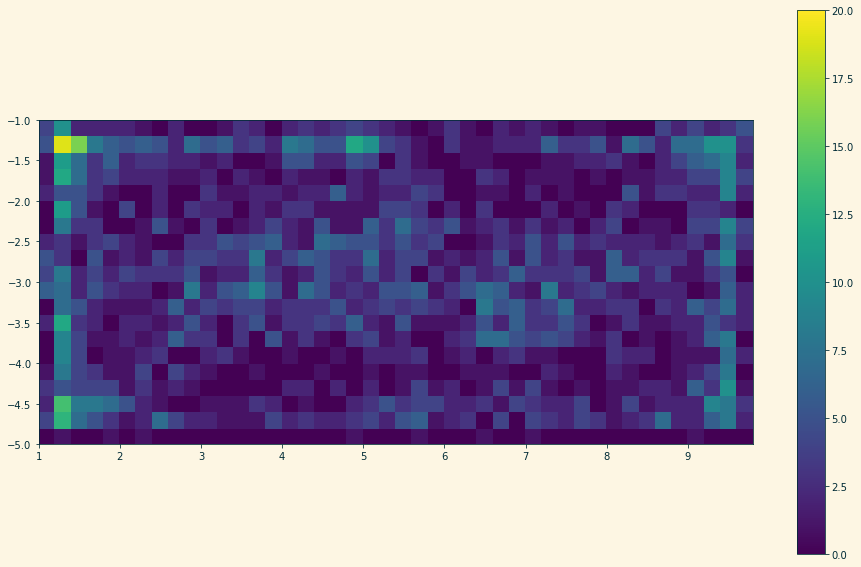

In [419]:
_ = plt.hist2d(w_df.x, w_df.z, bins=[np.arange(1, 10, 0.2), np.arange(-5, -0.8, 0.2)], cmap='viridis', vmin=0, vmax=20)
_ = plt.axes().set_aspect('equal')
_ = plt.colorbar()

### walls

In [335]:
ti = '/Users/schwenk/Downloads/floorplans'

In [348]:
allfloorplans = os.listdir(ti)

In [539]:
def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, threshd = cv2.threshold(img, 254, 255,cv2.THRESH_BINARY)
    threshd = (255 - threshd)
    return threshd[5:1300, 5:2900]

In [540]:
floorplan_images[0].shape

(1295, 2898)

In [541]:
floorplan_images = [read_img(os.path.join(ti, i)) for i in allfloorplans]

In [542]:
# Image.fromarray(floorplan_images[0])

In [544]:
fp_arr = np.zeros(floorplan_images[0].shape, np.float)
for im in floorplan_images:
    imarr = np.array(im, dtype=np.float)
    fp_arr = fp_arr + imarr / len(floorplan_images) 
fp_arr = np.array(np.round(fp_arr), dtype=np.uint8)

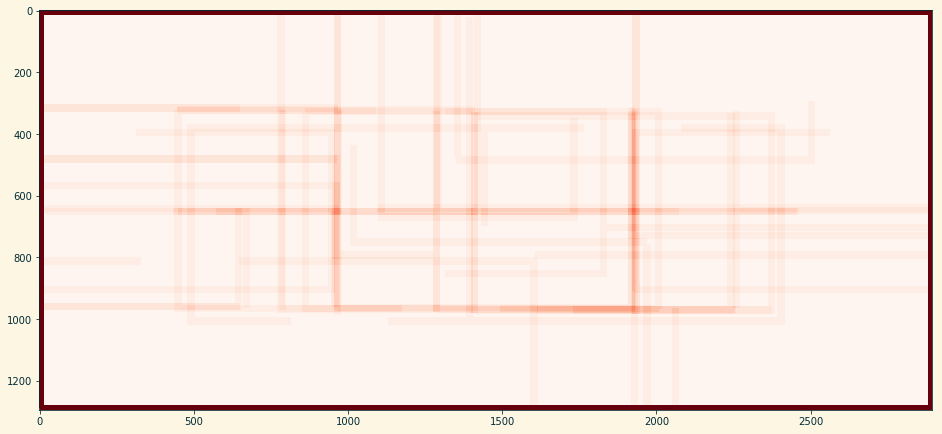

In [548]:
cmap = plt.get_cmap('Reds')

rgba_img = cmap(fp_arr)
rgb_img = np.delete(rgba_img, 3, 2)
_ = plt.axes().set_aspect('equal')
_= plt.imshow(rgb_img)

# Volume 

## # scenes

In [2]:
scene_names_df = pd.read_csv('/Users/schwenk/wrk/transfer/src/ai2thor/scene_list.txt', header=None)
scene_names_df.columns = ['name']

In [3]:
scene_names_df['split'] = scene_names_df.name.str.lower().str.split('_').apply(lambda x: ''.join([i for i in x[1].strip() if not i.isdigit()]))
scene_names_df.name = scene_names_df.name.str.strip()
scene_counts = pd.DataFrame(scene_names_df.split.value_counts())
all_scenes = scene_names_df.name.tolist()
scene_counts

,split
train,75
rtest,10
rval,4


## # assets

In [ ]:
furn_vs_obj_def = {
    'ArmChair': 'furniture',
    'Bed': 'furniture',
     'Book': 'object',
     'Bowl': 'object',
     'ButterKnife': 'object',
     'Chair': 'furniture',
     'CoffeeTable': 'furniture',
     'Desk': 'furniture',
     'DeskLamp': 'object',
     'DiningTable': 'furniture',
     'Dresser': 'furniture',
     'Fork': 'object',
     'HousePlant': 'object',
     'Mug': 'object',
     'Plate': 'object',
     'Shelf': 'furniture',
     'SideTable': 'furniture',
     'Sofa': 'furniture',
     'Vase': 'object',
}